In [5]:
### Install required libraries
!pip install pyyaml scikit-image trimesh matplotlib wandb deepdish plyfile gdown

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 696.3/696.3 kB 46.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 105.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.8/301.8 kB 23.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 5.3 MB/s eta 0:00:00


In [1]:
### Dowload model weights
!gdown 1qje3UvwKoa9zrtGLojbCwWlPW87SQTDJ ### All data model
!gdown 1KH66n47EhJQ6-GBtrAaml4W8I8U4OMgm ### Chairs model
!gdown 19J8v_gWY5TabCJlPzh4GOqGONrOML65O ### Tables model

Downloading...
From (original): https://drive.google.com/uc?id=1qje3UvwKoa9zrtGLojbCwWlPW87SQTDJ
From (redirected): https://drive.google.com/uc?id=1qje3UvwKoa9zrtGLojbCwWlPW87SQTDJ&confirm=t&uuid=1d004f11-90bb-4392-8454-c2c8483051e7
To: /content/all.pth
100% 35.2M/35.2M [00:02<00:00, 16.0MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1KH66n47EhJQ6-GBtrAaml4W8I8U4OMgm
From (redirected): https://drive.google.com/uc?id=1KH66n47EhJQ6-GBtrAaml4W8I8U4OMgm&confirm=t&uuid=09c54a68-c9cb-4807-9db9-98a96ed91342
To: /content/chairs.pth
100% 35.2M/35.2M [00:01<00:00, 18.1MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=19J8v_gWY5TabCJlPzh4GOqGONrOML65O
From (redirected): https://drive.google.com/uc?id=19J8v_gWY5TabCJlPzh4GOqGONrOML65O&confirm=t&uuid=1e705e34-9438-4f48-a820-76e9bca88be8
To: /content/tables.pth
100% 35.2M/35.2M [00:01<00:00, 24.2MB/s]


In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F


### A simple building block of the encoder network.
### Convolution -> BatchNormalization -> Activation
class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=0):
        super(EncoderBlock, self).__init__()
        self.conv = nn.Conv3d(in_channels, out_channels, kernel_size, stride, padding)
        self.norm = nn.BatchNorm3d(out_channels)
        self.act = nn.ELU()

    def forward(self, x):
        x = self.conv(x)
        x = self.norm(x)
        x = self.act(x)
        return x


### A simple building block of the encoder network.
### TransposeConvolution -> BatchNormalization -> Activation
class DecoderBlock(nn.Module):
    def __init__(
        self,
        in_channels,
        out_channels,
        kernel_size=3,
        stride=1,
        padding=0,
        output_padding=0,
        is_last_layer=False,
    ):
        super(DecoderBlock, self).__init__()
        self.conv = nn.ConvTranspose3d(
            in_channels,
            out_channels,
            kernel_size,
            stride,
            padding,
            output_padding=output_padding,
        )
        self.is_last_layer = is_last_layer

        ### If this is the last layer in the decoder network, we don't want any ELUactivations
        if not self.is_last_layer:
            self.norm = nn.BatchNorm3d(out_channels)
            self.act = nn.ELU()

    def forward(self, x):
        x = self.conv(x)
        if not self.is_last_layer:
            x = self.norm(x)
            x = self.act(x)
        return x


### Linear module for latent code
class LinearBlock(nn.Module):
    def __init__(self, in_features, out_features, use_batchnorm=True):
        super(LinearBlock, self).__init__()
        self.fc = nn.Linear(in_features, out_features)
        self.use_batchnorm = use_batchnorm
        if self.use_batchnorm:
            self.bn = nn.BatchNorm1d(out_features)

    def forward(self, x):
        x = self.fc(x)
        if self.use_batchnorm:
            x = self.bn(x)
        return x


class VoxelVAE(nn.Module):
    def __init__(self, args):
        super(VoxelVAE, self).__init__()
        self.latent_dim = args["latent_dim"]

        # Encoder
        self.encoder = nn.ModuleList(
            [
                EncoderBlock(
                    1, 8, kernel_size=3, stride=1, padding=0
                ),  # 32x32x32 -> 30x30x30
                EncoderBlock(
                    8, 16, kernel_size=3, stride=2, padding=1
                ),  # 30x30x30 -> 15x15x15
                EncoderBlock(
                    16, 32, kernel_size=3, stride=1, padding=0
                ),  # 15x15x15 -> 13x13x13
                EncoderBlock(
                    32, 64, kernel_size=3, stride=2, padding=1
                ),  # 13x13x13 -> 7x7x7
            ]
        )

        self.fc_mu = LinearBlock(64 * 7 * 7 * 7, self.latent_dim)
        self.fc_logvar = LinearBlock(64 * 7 * 7 * 7, self.latent_dim)

        # Decoder
        self.fc_decode = LinearBlock(self.latent_dim, 64 * 7 * 7 * 7)
        self.decoder = nn.ModuleList(
            [
                DecoderBlock(
                    64, 64, kernel_size=3, stride=1, padding=1
                ),  # 7x7x7 -> 7x7x7
                DecoderBlock(
                    64, 32, kernel_size=3, stride=2, padding=0
                ),  # 7x7x7 -> 15x15x15
                DecoderBlock(
                    32, 16, kernel_size=3, stride=1, padding=1
                ),  # 15x15x15 -> 15x15x15
                DecoderBlock(
                    16, 8, kernel_size=4, stride=2, padding=0, output_padding=0
                ),  # 15x15x15 -> 32x32x32
                DecoderBlock(
                    8, 1, kernel_size=3, stride=1, padding=1, is_last_layer=True
                ),  # 32x32x32 -> 32x32x32 (output layer)
            ]
        )

    def encode(self, x):
        for block in self.encoder:
            x = block(x)
        x = x.view(x.size(0), -1)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    ### Does the reparametrization technic in training VAEs, ensuring a differentiability through the stochastic sampling process
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        x = self.fc_decode(z)
        x = x.view(x.size(0), 64, 7, 7, 7)
        for block in self.decoder:
            x = block(x)
        x = torch.sigmoid(x)  ### Ensure output is in [0, 1]
        return x

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        return recon_x, mu, logvar


In [7]:
import numpy as np
import trimesh
from skimage import measure
import torch
from pathlib import Path
import matplotlib.pyplot as plt


### Runs marching cubes on a voxel grid and saves the generated mesh
def save_voxel_as_mesh(voxel, file_path):
    vertices, faces, normals, _ = measure.marching_cubes(voxel, level=0.5)

    mesh = trimesh.Trimesh(vertices=vertices, faces=faces, vertex_normals=normals)

    mesh.export(file_path)
    print(f"Mesh saved to {file_path}")

In [8]:
import argparse
import torch
from pathlib import Path
import matplotlib.pyplot as plt
import yaml


### Takes a model checkpoint path and generates samples from the trained model
class InferVAE:
    def __init__(
        self,
        config,
        checkpoint_path,
        output_dir,
    ):

        if checkpoint_path is None:
            raise ValueError("You must provide a valid checkpoint_path.")

        self.config = config

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.model = VoxelVAE(args=self.config["model"]).to(self.device)

        ### Load the weights to the model
        self.model.load_state_dict(torch.load(checkpoint_path))
        self.model.eval()

        self.output_dir = Path(output_dir)
        self.output_dir.mkdir(parents=True, exist_ok=True)

    ### Samples from normal distribution and feeds it through the decoder
    def sample(self, num_samples=8):
        with torch.no_grad():
            z = torch.randn(num_samples, self.model.latent_dim).to(self.device)
            samples = self.model.decode(z).cpu().numpy()
        return samples

    ### Generates meshes and plots by sampling from the latent space
    def generate_and_save(self, num_samples=8):
        samples = self.sample(num_samples=num_samples)
        samples = samples.squeeze()

        for i in range(samples.shape[0]):
            voxel_grid = samples[i]

            file_path = self.output_dir / f"sample_{i}.obj"
            save_voxel_as_mesh(voxel_grid, file_path)
            print(f"Saved sample {i} as {file_path}")

            self.save_voxel_image(voxel_grid, i)

    def save_voxel_image(self, voxel_grid, index):
        fig = plt.figure(figsize=(8, 8))
        ax = fig.add_subplot(111, projection="3d")
        ax.voxels(voxel_grid > 0.5, facecolors="cyan", edgecolor="k")
        ax.set_axis_off()
        ax.view_init(elev=30, azim=45)
        plt.savefig(self.output_dir / f"sample_{index}.png")
        plt.close(fig)


In [9]:
global_config = {
    'data': {
        'dataset_path': 'data/',  # default dataset path
        'batch_size': 64,
        'shuffle': True,
        'num_workers': 4,
        'class_code': '03001627',  # Class code -> Chairs: 03001627, Tables: 04379243
        'split_ratio': 0.8  # Training to testing ratio
    },
    'training': {
        'epochs': 100,
        'learning_rate': 1e-4,
        'gamma': 0.97,  # Hyperparameter for modified BCE
        'checkpoint_freq': 20,  # Frequency (in epochs) to save model checkpoints
        'visualize_freq': 20  # Frequency (in epochs) to visualize network output
    },
    'model': {
        'latent_dim': 128,
        'type': 'VAE'
    }
}

In [16]:
ckpt_path_chair = Path('chairs.pth')
ckpt_path_table = Path('tables.pth')
ckpt_path_all = Path('all.pth')

out_folder = 'infer_output'

infer_vae = InferVAE(
    config=global_config,
    checkpoint_path=ckpt_path_chair,
    output_dir=out_folder,
)
infer_vae.generate_and_save(num_samples=8)

Mesh saved to infer_output/sample_0.obj
Saved sample 0 as infer_output/sample_0.obj
Mesh saved to infer_output/sample_1.obj
Saved sample 1 as infer_output/sample_1.obj
Mesh saved to infer_output/sample_2.obj
Saved sample 2 as infer_output/sample_2.obj
Mesh saved to infer_output/sample_3.obj
Saved sample 3 as infer_output/sample_3.obj
Mesh saved to infer_output/sample_4.obj
Saved sample 4 as infer_output/sample_4.obj
Mesh saved to infer_output/sample_5.obj
Saved sample 5 as infer_output/sample_5.obj
Mesh saved to infer_output/sample_6.obj
Saved sample 6 as infer_output/sample_6.obj
Mesh saved to infer_output/sample_7.obj
Saved sample 7 as infer_output/sample_7.obj


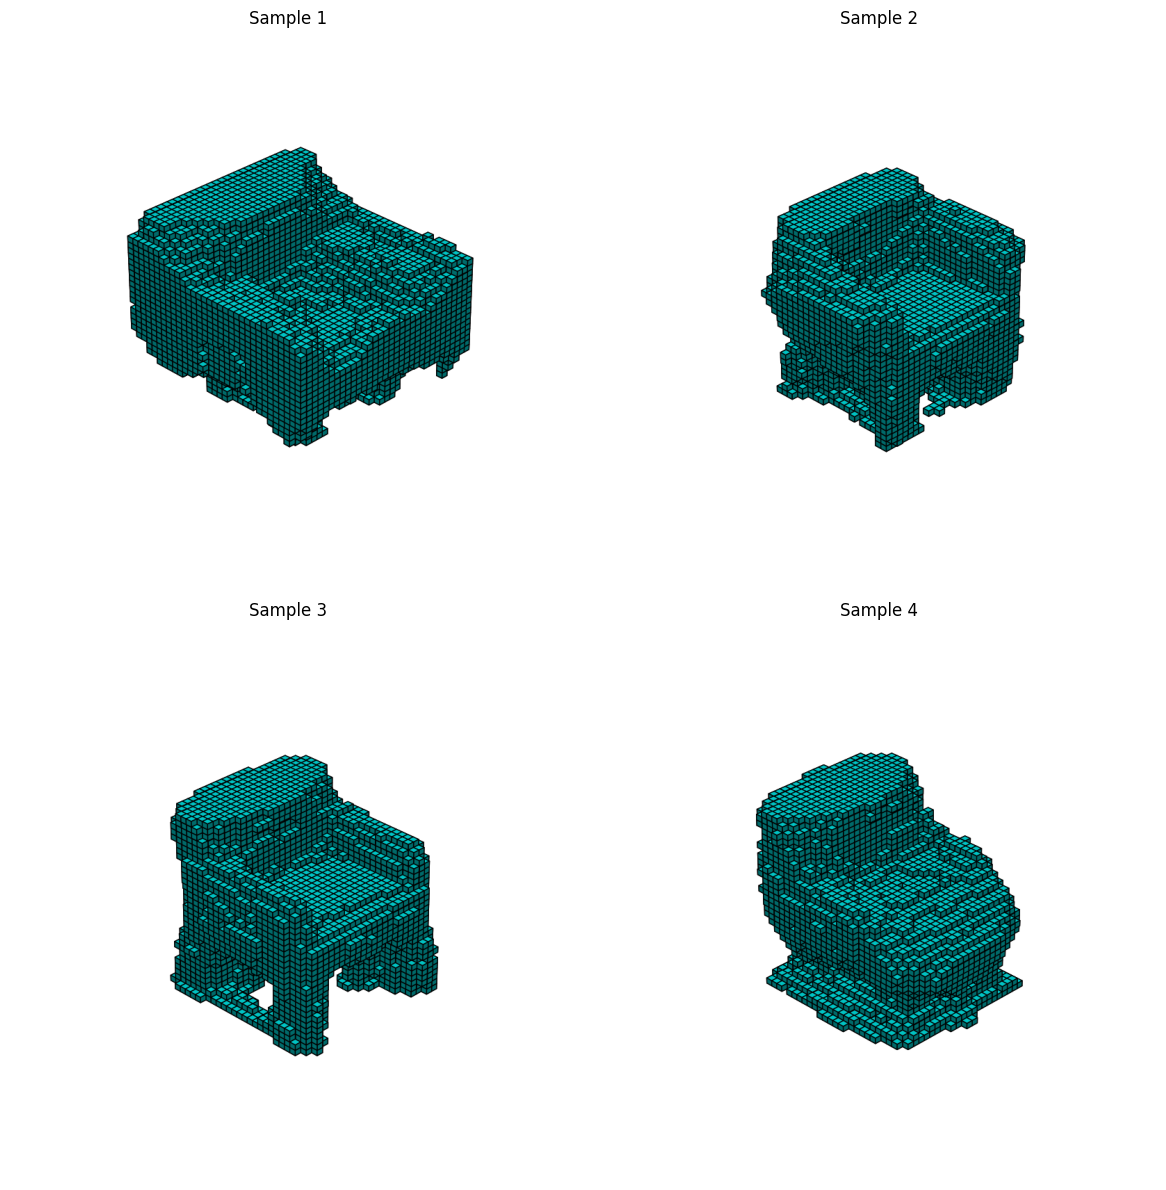

In [17]:
from PIL import Image

out_dir = Path(out_folder)
image_files = sorted(list(out_dir.glob('*.png')))[:4]
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
axes = axes.flatten()

for i, image_file in enumerate(image_files):
    img = Image.open(image_file)
    axes[i].imshow(img)
    axes[i].set_title(f'Sample {i+1}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()